# Simulation de procéssus aléatoires

In [7]:
#IMPORTATIONS 
import numpy as np 
import sys
import random
import matplotlib.animation as animation
from matplotlib import pyplot as plt
import pydot 
import time
import scipy.sparse as spsp 
import scipy as sp
from IPython.display import Image, display
import networkx as nx
%matplotlib inline


In [42]:
""" Config pour l'animation """

from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

In [43]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

## 1) Modèle de Ising (Glauber Dynamics)

In [44]:

class Ising : 
    def __init__(self, n,b) : 
        self.n = n 
        self.b = b
        self.tore = np.zeros((n,n)) 
        for i in range(n) : 
            for j in range(n) : 
                r = random.random() 
                if( r <1./2) : 
                    self.tore[i,j] = 1 
                else : 
                    self.tore[i,j] = -1 

    def D(self,i,j) : 
        b =self.tore[((i+1)%n,j)] 
        h =self.tore[((i+(n-1))%n,j)] 
        g =self.tore[(i,(j+1)%n)] 
        d = self.tore[(i,(j+n-1)%n)]  
        return b + h + g + d

    def next_step(self)  : 
            i = random.randint(0,self.n-1) 
            j = random.randint(0,self.n-1) 
            t = np.tanh(self.b*(self.D(i,j))) 
            p = (1+t)/2
            r = random.random() 
            if ( r < p ) :
                self.tore[i,j] = 1
            else : 
                self.tore[i,j] = -1
    
    def run(self,N) : 
        for i in range(N) : 
            self.next_step() 


    def afficher(self) : 
        X = []
        Y = [] 
        for i in range(n) :
            for j in range(n) : 
                if(self.tore[i][j] == -1) : 
                    self.tore[i,j] == 0 
                if (self.tore[i][j] == 1)  :
                    X.append(i)
                    Y.append(j) 
        plt.figure(figsize=(6,6))
        plt.imshow(self.tore)
        plt.show()
        plt.scatter(X,Y,s=0.1)
        plt.savefig("torus"+str(self.b)+".png") 



In [52]:
#LONG
n = 250
B = 0.01
temp = 1./float(B) 
T = Ising(n,B)
fig = plt.figure(figsize=(6,6)) 
plt.title("Ising T ="+str(temp))
im = plt.imshow(T.tore,cmap = "binary") 
def animate(i) : 
    for i in range(500) : 
        T.next_step() 
    im.set_array(T.tore) 
    return(im,) 
anim = animation.FuncAnimation(fig, animate, frames = 1000, interval = 1) 
display_animation(anim)

In [46]:
#LONG
n = 250
B = 10
temp = 1./float(B) 
T = Ising(n,B)
fig = plt.figure(figsize=(6,6)) 
plt.title("Ising T ="+str(temp))
im = plt.imshow(T.tore,cmap = "binary") 
def animate(i) : 
    for i in range(500) : 
        T.next_step() 
    im.set_array(T.tore) 
    return(im,) 
anim = animation.FuncAnimation(fig, animate, frames = 1000, interval = 1) 
display_animation(anim)

## 2) Marche aléatoire sur le n-cycle

In [3]:
class Node :

        
        def __init__(self, d,deg = 0) :
                self.ide = d #identifiant
                self.Le = [] #liste d'Arcs entrants
                self.Ls = [] #liste d'Arcs sortants  
                self.deg = deg 
                self.S = None 

class Edge :

        def __init__(self, n1, n2,p) :
                self.p = p #proba associee a l'arc
                self.tail = n1
                self.head = n2 
                n1.Ls.append(self) 
                n2.Le.append(self)
                self.c = (n1.ide,n2.ide)
                n1.deg = n1.deg + 1 
                
                
class Graph : 

        def __init__(self, ma) :
                self.liste = [Node(i) for i in range(ma)] #Liste de noeuds du graphe de transition
                self.m =  None #representation de la matrice de transition 
                self.Nbmax = ma
                self.PI = None 
                self.E = 0 
        


        def addArc(self, tail, head) : 
                """ Verification de coherance de l'ajout """ 
                for edge in self.liste[tail].Ls  :  
                    if(( tail == edge.c[0] and head == edge.c[1])):
                            if( y == 1) : 
                                return False 
                Edge(self.liste[tail],self.liste[head],None) 
                self.E = self.E + 1 
    
        def UpdateProbas(self) : 
                self.m = np.zeros((self.Nbmax,self.Nbmax)) 
                PI = np.zeros(len(self.liste))
                for noeud in self.liste :
                        if len(noeud.Ls) == 0 : #Cas ou le noeud n'as pas d'arcs sortants 
                            self.m[noeud.ide][noeud.ide] = 1 
                        else : 
                                for arc in noeud.Ls : 

                                        p = 1./noeud.deg  #distribution uniforme sur les arcs sortants 
                                        arc.p = p
                                        self.m[arc.tail.ide][arc.head.ide] = p 
                                PI[noeud.ide] = float(noeud.deg)/(self.E)
                                
                self.PI = PI 
                return True 
        
        
        def Afficher(self,titre = None) : 
                graph = pydot.Dot(graph_type= 'digraph',ratio = "1.0") 

                for noeud in self.liste : 
                        for arc in noeud.Ls : 
                                edge = pydot.Edge(str(arc.c[0]),str(arc.c[1]), label="{:.3f}".format(arc.p),color="red")
                                graph.add_edge(edge)
                
                
                plt = Image(graph.create_png())
                display(plt)
        def Dist(self,seuil,N,s=1, vartot = 1, creux = 0  ) :  
                tmp = self.m
                res = self.m
                eps = []
                cpt = N 
                if( creux ==1 )  : 
                    M_c = spsp.csr_matrix(np.transpose(tmp)) 
                    MU = np.eye(len(self.liste)) 
                    for i in range(N) :
                        debut = time.time()
                        tmp = MU[0] 
                        MU[0] = M_c.dot(MU[0])
                        # CALCUL UNIQUEMENT SUR 1 x (pas de max)
                        t_eps = (1./2*(sum(abs(tmp-1./len(self.liste))))) 
                        eps.append(t_eps) 
                        fin = time.time() 
                        if(i == 1) : 
                                print("Temps estimé:")
                                TMP = int(N*(fin-debut))
                                h = TMP/3600 ; TMP %= 3600
                                minu = TMP/60 ; TMP%=60 
                                stri = str(h) + "h , " + str(minu) + "min , " + str(TMP) + "sec" 
                                print(stri) 
                        if(eps[i] < seuil) : 
                            cpt = i+1
                            break 
                    
                else : 
                    for i in range(N) : 
                            debut = time.time() 
                            test = np.dot(res,res) 
                            tmp = np.dot(res,self.m)     
                            res2 = 0 
                            a= 0 
                            for k in range(len(self.liste)) : 
                                tmp2 = 1./2*(sum(abs(tmp[k]-self.PI)))
                                if (tmp2> a) :
                                    a = tmp2
                            eps.append(a)                     
                            fin = time.time() 
                            if(i == 1) : 
                                print("Temps estime:")
                                TMP = int(N*(fin-debut))
                                h = TMP/3600 ; TMP %= 3600
                                minu = TMP/60 ; TMP%=60 
                                stri = str(h) + "h , " + str(minu) + "min , " + str(TMP) + "sec" 
                                print(stri) 
                            
                            res = tmp 

                            if(eps[i] < seuil) : 
                                    cpt = i+1
                                    break 
                if(s==1) : #affichage

                    fig = plt.figure(figsize= (6,6))
                    plt.plot(range(cpt),eps) 
                    plt.xlabel("$t$") 
                    plt.ylabel("$d(t)$") 
                    plt.title("d(t)  [$t_{mix}($"+str(eps[i])+"$) =$"+str(i)+"]") 
                    plt.show()
                
                Result = (res,i,eps)
                return Result 
        
                
        
        

On définit la marche aléatoire sur le n-cycle comme la marche aléatoire sur $\mathbb{Z}/n\mathbb{Z}$ avec comme distribution d'incrément $\mu$ vérifiant $\mu(1)=\mu(-1)=1/2$. i.e la chaine dont la matrice de transistion est $P(g,(g+1)\%n)=P(g,(g+n-1)\%n)=1/2$


In [4]:

def Cycle(n) :
    Graphe = Graph(n)  
    Graphe.liste = [Node(i) for i in range(n)] 
    for i in range(n) : 
        Graphe.addArc(i,(i+1)%(n))
        Graphe.addArc(i,(i+(n-1))%(n))
    Graphe.UpdateProbas() 
    return(Graphe) 

def Lazy_Cycle(n) :
    Graphe = Graph(n)  
    Graphe.liste = [Node(i) for i in range(n)] 
    for i in range(n) : 
        Graphe.addArc(i,(i+1)%(n))
        Graphe.addArc(i,(i+(n-1))%(n))
        Graphe.addArc(i,i)
        Graphe.m = np.zeros((n,n)) 
        PI = np.zeros(n)
    for noeud in Graphe.liste :
        for arc in noeud.Ls :
            if arc.tail.ide == arc.head.ide :
                arc.p = float(0.5)
            else : 
                arc.p = float(0.25)
                PI[noeud.ide] = 1./n
    for i in range(n) : 
        Graphe.m[i][i] = 0.5 
        Graphe.m[i][(i+1)%n] = 0.25
        Graphe.m[i][(i+(n-1))%n] = 0.25 
    Graphe.PI = PI
    return Graphe



Représentation du graphe (n=5) : 

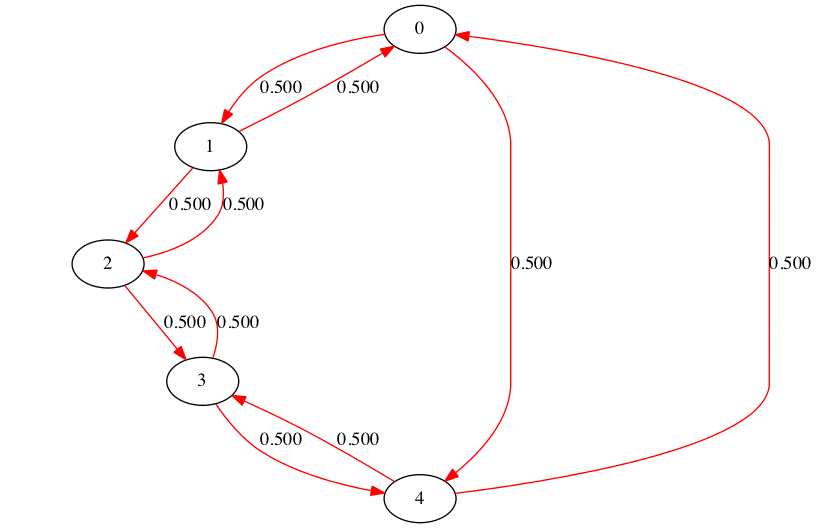

In [49]:

G = Cycle(5)
G.Afficher()


Temps estimé:
0h , 0min , 13sec


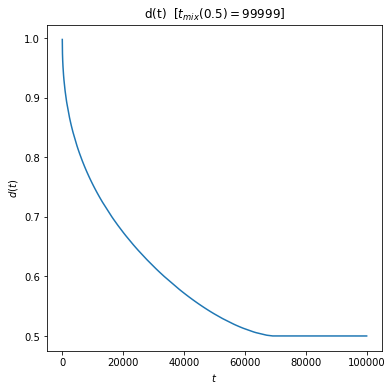

In [50]:
G = Cycle(1000)
P = G.Dist(0.1,100000,vartot = 1,creux = 1)

Pour la marche alétoire simple sur le n-cycle il la distance en varation totale ne déscend pas en dessosu de 0.5 à cause de la périodicité. On concidère donc la version "lazy" qui a la même distribution stationnaire et règle le problème de périodicité. À chaque étape, on reste à la même position avec probabilité 1/2 et on change selon la régle précedante avec probabilité 1/2. Le graphe correspondant est le suivant  : 

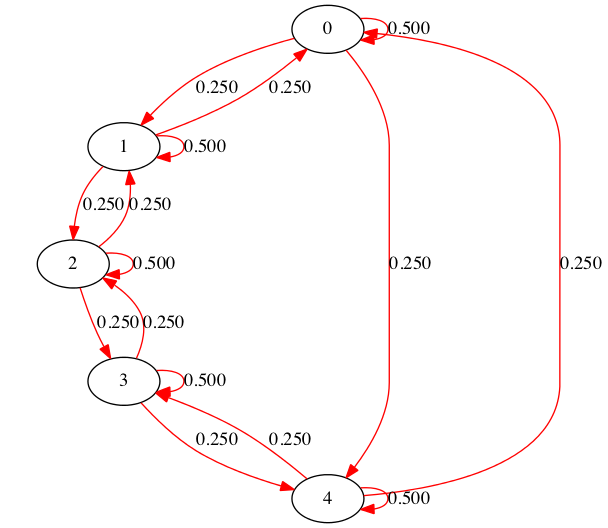

In [51]:
G = Lazy_Cycle(5)
G.Afficher()


Temps estimé:
0h , 0min , 13sec


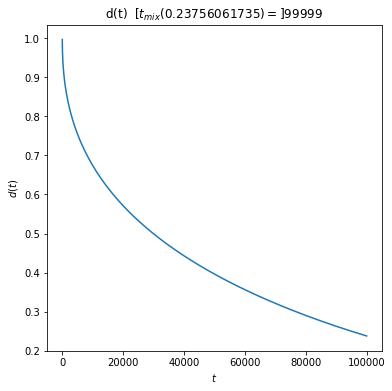

In [11]:
G = Lazy_Cycle(1000)
P = G.Dist(0.1,100000,vartot = 1,creux = 1)

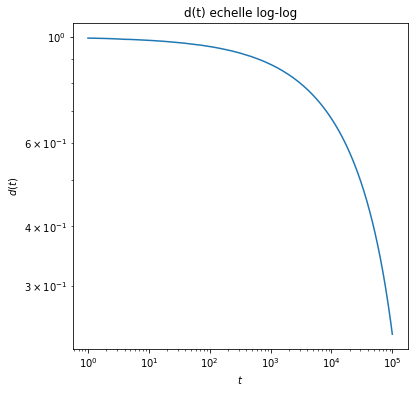

In [12]:
len(P[2])
fig = plt.figure(figsize= (6,6))
plt.loglog(range(100000),P[2]) 
plt.xlabel("$t$") 
plt.ylabel("$d(t)$") 
plt.title("d(t) echelle log-log") 
plt.show()

## 3) Modèle de configuration : 

Visualisation d'un graphe tiré selon le modèle de configuration (en utilisant la bibliothèque networkx)

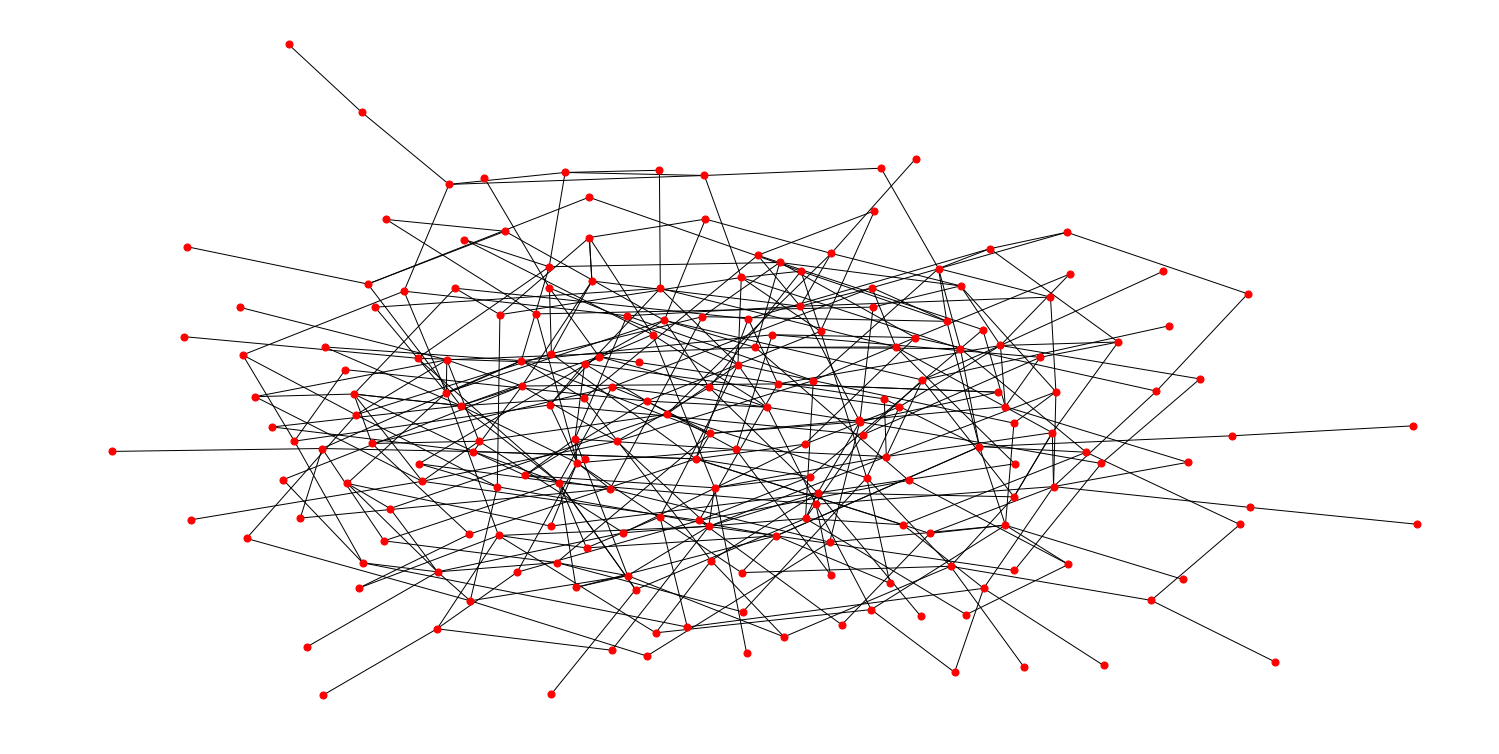

In [16]:
import numpy.random as rd
D = rd.poisson(4, 200)
G =nx.configuration_model(D)

pos = nx.kamada_kawai_layout(G)


nx.draw(G,pos,node_size=50)

In [5]:
def Config_Model(n,d,nb = True): 
    Graphe = Graph(sum(d))
    M = np.zeros((sum(d),sum(d))) 
    h_edges = []
    sig = dict()
    ADJ = np.zeros((len(d),len(d)))
    for i in range(n) : 
        for j in range(d[i]) : 
            h_edges.append((i,j))
    while(len(h_edges) > 0) :         
        x = random.choice(h_edges) 
        h_edges.remove(x) 
        y = random.choice(h_edges)
        h_edges.remove(y) 
        ADJ[x[0],y[0]] = 1
        ADJ[y[0],x[0]] = 1 
        sig[(x[0],x[1])] = (y[0],y[1]) 
        sig[(y[0],y[1])] = (x[0],x[1]) 

    for e in sig.keys()  :
        n= d[sig[e][0]] 
        if(nb == True) : 
            for i in range(n) :
                if(i != sig[e][1]) :
                    M[sum(d[0:e[0]]) +e[1] , sum(d[0:sig[e][0]]) + i] = 1./(n-1)
        else : 
            for i in range(n) :
                M[sum(d[0:e[0]]) +e[1] , sum(d[0:sig[e][0]]) + i] = 1./n
 
    Graphe.m = M 
    return(Graphe,ADJ)



**Distance en variation totale pour la marche aléatoire sans rebroussement sur un graphe 6-régulier  à 5000 sommets  généré par le modèle de configuration**

Temps estimé:
0h , 0min , 0sec


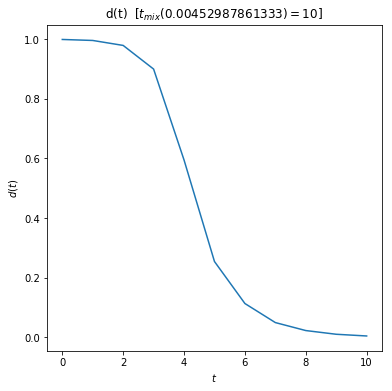

In [9]:
n= 1000
d= 6 
D = [ d for i in range(n)] 
Graphe,ADJ = Config_Model(n,D) 
P = Graphe.Dist(0.01,30,vartot= 1 , creux = 1 ) 

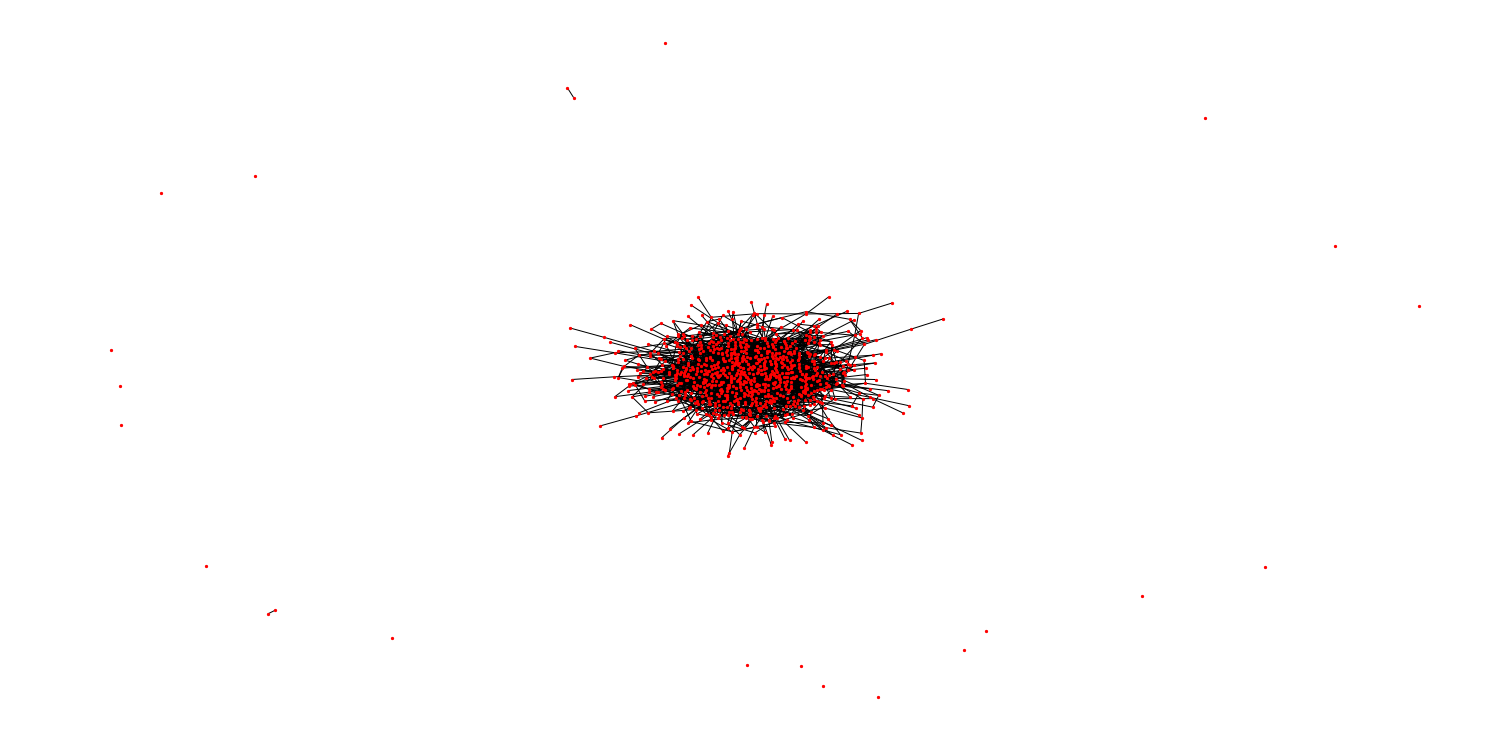

In [26]:
D = rd.poisson(4, 1000)
adj = Config_Model(1000,D)[1]
G = nx.from_numpy_matrix(adj)
pos = nx.fruchterman_reingold_layout(G)
plt.figure(figsize=(20,10))
nx.draw(G,pos,node_size=5)

In [128]:
n= 500
d= 6 
D = [ d for i in range(n)] 
Graphe,ADJ = Config_Model(n,D)
G = nx.from_numpy_matrix(ADJ)
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(20,10))
nx.draw(G,pos,node_size=5)

TypeError: Config_Model() takes at least 3 arguments (2 given)

**Distance en variation totale pour la marche aléatoire sur un graphe 6-régulier  à 5000 sommets  généré par le modèle de configuration**

Temps estimé:
0h , 0min , 0sec


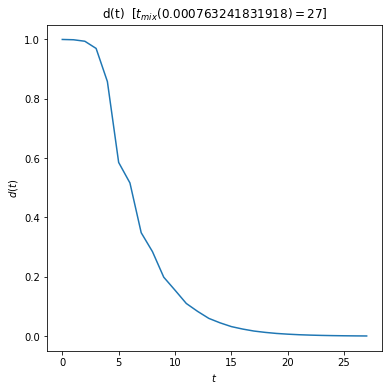

In [8]:
n= 5000
d= 6 
D = [ d for i in range(n)] 
Graphe = Config_Model(n,D,nb =0 ) 
P = Graphe.Dist(0.001,30,vartot= 1 , creux = 1) 

In [115]:
def Com_Config_Model(d1,d2,in_p,nb = True): 
    d = d1+d2
    s = sum(d1)
    Graphe = Graph(sum(d))
    M = np.zeros((sum(d),sum(d))) 
    h1_edges = dict()
    h2_edges = dict()
    out1 = []
    out2 = []
    sig = dict()
    ADJ = np.zeros((len(d),len(d)))
    
    ###INITIALISATION ###
    nb_out = 0
    nin = 0 
    for i in range(len(d1)) : 
        for j in range(d1[i]) : 
            if(random.random()> in_p ):
                out1.append((i,j))
                nb_out = nb_out +1
            else :
                h1_edges[(i,j)] = "in"
                nin = nin  + 1 
    tmp = []
    s = len(h1_edges.keys())

    if (s%2 == 1) : ## Pour garder une somme de degre pair  
        x = random.choice(out1)
        out1.remove(x)
        h1_edges[x] = "in"
        nb_out = nb_out - 1 

    for i in range(len(d2)) : 
        for j in range(d2[i]) : 
            tmp.append((i,j))
    out_i = random.sample(tmp,nb_out)

    for i in range(len(d2)) : 
        for j in range(d2[i]) : 
            if((i,j) in out_i):
                out2.append((i,j))
            else :
                h2_edges[(i,j)] = "in"
    
    ### PAIRING ###
    #I 1er modele de config + matching des "out"
    
    while(len(h1_edges.keys()) > 0) :         
        x = random.choice(h1_edges.keys()) 
        h1_edges.pop(x)
        y = random.choice(h1_edges.keys())
        h1_edges.pop(y)
        ADJ[x[0],y[0]] = 1
        ADJ[y[0],x[0]] = 1 
        sig[(x[0],x[1])] = (y[0],y[1]) 
        sig[(y[0],y[1])] = (x[0],x[1]) 

        
    #II 2eme modele de config
       
    while(len(h2_edges.keys()) > 0) :         
        x = random.choice(h2_edges.keys()) 
        h2_edges.pop(x) 
        y = random.choice(h2_edges.keys())
        h2_edges.pop(y)
        ADJ[len(d1)+x[0],len(d1)+y[0]] = 1
        ADJ[len(d1)+y[0],len(d1)+x[0]] = 1 
        sig[(len(d1)+x[0],x[1])] = (len(d1)+y[0],y[1]) 
        sig[(len(d1)+y[0],y[1])] = (len(d1)+x[0],x[1]) 
    
    #III 3eme modele de config (matching des "out")
       
    while(len(out1)>0) : 
        x = random.choice(out1)
        out1.remove(x)
        y = random.choice(out2)
        out2.remove(y)
        ADJ[x[0],len(d1)+y[0]] = 1
        ADJ[len(d1)+y[0],x[0]] = 1 
        sig[(x[0],x[1])] = (len(d1)+y[0],y[1]) 
        sig[(len(d1)+y[0],y[1])] = (x[0],x[1]) 
       
       
       
       
    for e in sig.keys()  :
        n= d[sig[e][0]] 
        if(nb == True) : 
            for i in range(n) :
                if(i != sig[e][1]) :
                    M[sum(d[0:e[0]]) +e[1] , sum(d[0:sig[e][0]]) + i] = 1./(n-1)
        else : 
            for i in range(n) :
                M[sum(d[0:e[0]]) +e[1] , sum(d[0:sig[e][0]]) + i] = 1./n
 
    Graphe.m = M 
    return(Graphe,ADJ)


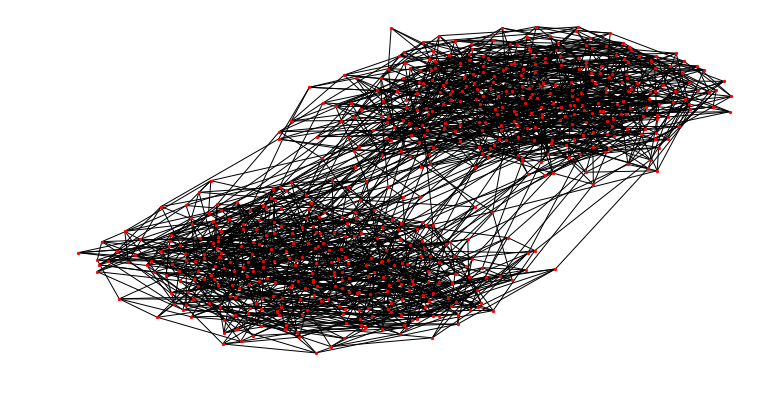

In [123]:
n= 1000
d= 6 
p= 0.95
D = [ d for i in range(300)]
Graphe,ADJ = Com_Config_Model(D,D,p)
G = nx.from_numpy_matrix(ADJ)
pos = nx.fruchterman_reingold_layout(G)
plt.figure(figsize=(20,10))
nx.draw(G,pos,node_size=5)


Temps estimé:
0h , 0min , 0sec


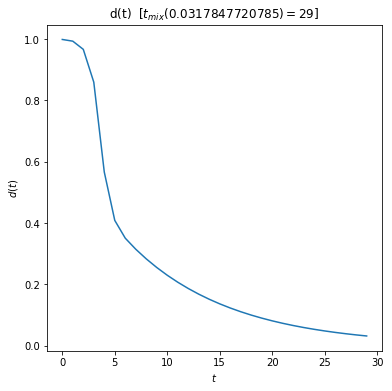

In [126]:
P = Graphe.Dist(0.001,30,vartot= 1 , creux = 1) 

Temps estimé:
0h , 0min , 0sec


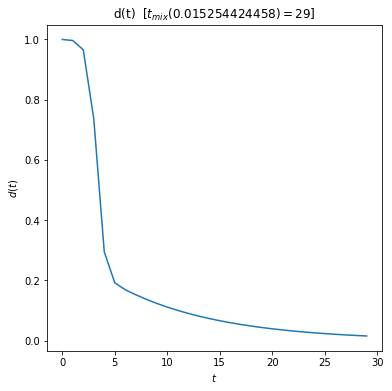

In [127]:
n= 1000
d= 10
p= 0.95
D = [ d for i in range(n)]
Graphe,ADJ = Com_Config_Model(D,D,p)
P = Graphe.Dist(0.001,30,vartot= 1 , creux = 1) 